# Box Atlas Value Function Intervals

I want to determine if I can collect reasonable intervals for the box atlas value function without spending oodles of time solving MIQPs. 

To do that, I'm going to sweep along a single parameter and then plot the resulting intervals with some sort of early-termination criterion. 

In [1]:
using Revise

In [2]:
using MeshCat
using MeshCatMechanisms
using RigidBodyDynamics
using JuMP
using Gurobi
using JLD2
using FileIO
using Plots; gr()

Plots.GRBackend()

In [3]:
import LCPSim
import BoxValkyries

INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/BoxValkyries.ji for module BoxValkyries.


In [4]:
robot = BoxValkyries.BoxValkyrie()
mvis = MechanismVisualizer(robot)
IJuliaCell(mvis)

Listening on 127.0.0.1:7000...
zmq_url=tcp://127.0.0.1:6000
web_url=http://127.0.0.1:7000/static/


MeshCat.IJuliaCell(MeshCat.ViewerWindow(ZMQ.Context(Ptr{Void} @0x0000000006566840, ZMQ.Socket[ZMQ.Socket(Ptr{Void} @0x000000000659d290, Base.Filesystem._FDWatcher(Ptr{Void} @0x0000000006584070, 55, (1, 0), Condition(Any[]), (false, false), 0))]), ZMQ.Socket(Ptr{Void} @0x000000000659d290, Base.Filesystem._FDWatcher(Ptr{Void} @0x0000000006584070, 55, (1, 0), Condition(Any[]), (false, false), 0)), "http://127.0.0.1:7000/static/", "tcp://127.0.0.1:6000", MeshCat.ZMQServer.ZMQWebSocketBridge(ip"127.0.0.1", Set{WebSockets.WebSocket}(), MeshCat.SceneTrees.SceneNode(Nullable{Array{UInt8,1}}(), Nullable{Array{UInt8,1}}(), Dict("meshcat"=>MeshCat.SceneTrees.SceneNode(#NULL, #NULL, Dict("robot"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74], Dict("world"=>MeshCat.SceneTrees.SceneNode(#NULL, #NULL, Dict("dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x6c, 0x64, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("base"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x64, 0x75, 0x6d, 0x6d, 0x79, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict("core"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x62, 0x61, 0x73, 0x65, 0x2f, 0x63, 0x6f, 0x72, 0x65], Dict("rh_dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x2f, 0x72, 0x68, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("after_core_to_rh_rotation"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x5f, 0x72, 0x6f, 0x74, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict("geometry_2"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], Dict{String,MeshCat.SceneTrees.SceneNode}()))),"rh"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x2f, 0x72, 0x68], Dict("after_core_to_rh_extension"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x65, 0x78, 0x74, 0x65, 0x6e, 0x73, 0x69, 0x6f, 0x6e], Dict("geometry_3"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], Dict{String,MeshCat.SceneTrees.SceneNode}()))))))),"rf_dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x2f, 0x72, 0x66, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("after_core_to_rf_rotation"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x5f, 0x72, 0x6f, 0x74, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict("geometry_6"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], Dict{String,MeshCat.SceneTrees.SceneNode}()))),"rf"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x2f, 0x72, 0x66], Dict("after_core_to_rf_extension"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x65, 0x78, 0x74, 0x65, 

In [28]:
xstar = BoxValkyries.nominal_state(robot)
mpc_params = LearningMPC.MPCParams(
    Δt=0.05,
    horizon=10,
    mip_solver=GurobiSolver(Gurobi.Env(), OutputFlag=0, 
        TimeLimit=5,
        FeasibilityTol=1e-3),
    lcp_solver=GurobiSolver(Gurobi.Env(), OutputFlag=0))

Q, R = BoxValkyries.default_costs(robot)
feet = findbody.(robot.mechanism, ["lf", "rf"])
lqrsol = LearningMPC.LQRSolution(xstar, Q, R, mpc_params.Δt, Point3D.(default_frame.(feet), 0., 0., 0.))
# lqrsol.S .= 1 ./ mpc_params.Δt .* Q

mpc_controller = LearningMPC.MPCController(robot.mechanism, 
    robot.environment, mpc_params, lqrsol, 
    [lqrsol]);

sample_sink = LearningMPC.MPCSampleSink{Float64}(true)
playback_sink = LearningMPC.PlaybackSink(mvis, mpc_params.Δt)

mpc_controller.callback = LearningMPC.call_each(
    sample_sink,
    playback_sink,
)

Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::#35) (generic function with 1 method)

In [29]:
x0 = BoxValkyries.nominal_state(robot)

MechanismState{Float64, Float64, Float64, …}(…)

In [30]:
mpc_controller(x0)

10-element Array{Float64,1}:
 0.0        
 0.0        
 0.24525    
 0.24525    
 2.22045e-16
 2.22045e-16
 0.0        
 0.0        
 5.3955     
 5.3955     

In [33]:
empty!(sample_sink)
for v_x in linspace(-6, 6, 31)
    x0 = BoxValkyries.nominal_state(robot)
    set_velocity!(x0, findjoint(robot.mechanism, "base_x"), v_x)
    mpc_controller(x0)
end

In [34]:
jldopen("results.jld2", "w") do file
    file["samples"] = sample_sink.samples
    file["lqrsol"] = lqrsol
    file["mpc_params"] = Dict(
            "Δt" => mpc_params.Δt,
            "horizon" => mpc_params.horizon,
        )
end

Dict{String,Any} with 2 entries:
  "horizon" => 10
  "Δt"      => 0.05

In [31]:
v_x = 2.8
x0 = BoxValkyries.nominal_state(robot)
set_velocity!(x0, findjoint(robot.mechanism, "base_x"), v_x)
model, results = LCPSim.optimize(x0, robot.environment, 
    mpc_params.Δt, mpc_params.horizon, Model(solver=GurobiSolver(OutputFlag=0, TimeLimit=60)))
@objective model Min LearningMPC.lqr_cost(results, lqrsol) + LearningMPC.joint_limit_cost(results)
solve(model)
@show LearningMPC.lqr_cost(getvalue.(results), lqrsol)

Academic license - for non-commercial use only
LearningMPC.lqr_cost(getvalue.(results), lqrsol) = 8.363814447169169


8.363814447169169

In [35]:
sample_sink.samples[23]

LearningMPC.Sample{Float64}([0.0, 1.05, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.8, 0.8, 2.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … -3.55271e-15 0.0; … ; 15.3948 -0.0147939 … -3.74937 0.145597; 9.96211 0.131402 … 0.0279057 -3.70211], [45.4887], LearningMPC.MIPResults
  solvetime_s: Float64 5.015228033065796
  objective_value: Float64 8.863797528228856
  objective_bound: Float64 8.54204335278888
)

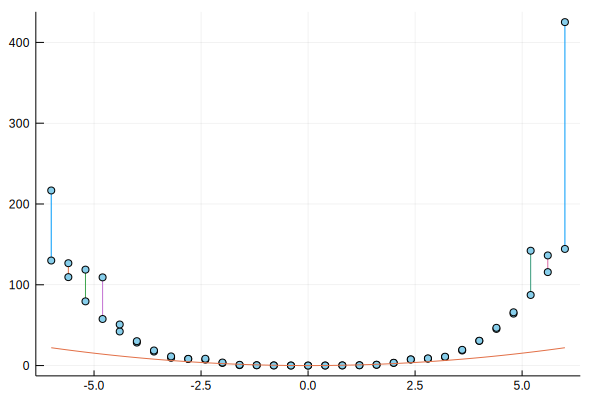

In [41]:
plt = plot(legend=nothing)
for sample in sample_sink.samples
    plot!(plt, [sample.state[11], sample.state[11]], 
            [sample.mip.objective_bound, sample.mip.objective_value],
        marker=:circle,
        markercolor="skyblue"
        )
end

x0 = BoxValkyries.nominal_state(robot)
plot!(plt, linspace(-6, 6, 101), function (v_x)
    set_velocity!(x0, findjoint(robot.mechanism, "base_x"), v_x)
    x = Vector(x0)
    (x - lqrsol.x0)' * lqrsol.S * (x - lqrsol.x0)
end
    )
# ylims!(plt, (-10, 300))
plt

In [42]:
savefig("value-function-intervals.png")
savefig("value-function-intervals.pdf")